# Preamble

This notebook makes use of the preprocessed images generated in notebook 1, so make sure to have those in place first.
Also, this notebook relies on the csv files in TRAIN_MIDSAMP_DF, VAL_DF, TEST_DF that are generated in notebook 2. So make sure to run notebook 2 until the creation of those dataframes in Section 2 (Setting up datasets) at least before attempting to run this one.

## Loading libraries

In [1]:
import gc       # garbage collector
from keras import backend as K  


import numpy as np
import pandas as pd

# graphics
import seaborn as sns
import matplotlib.pyplot as plt

# TF and Keras
import tensorflow as tf
import keras.optimizers


from keras import layers, models
#from keras.utils import to_categorical
from keras.applications import mobilenet_v2, resnet_v2, efficientnet_v2

from keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from keras.applications.efficientnet_v2 import preprocess_input as efficient_preprocess

# tweaks for GPU, could be disabled if not running on compatible GPU (but bring a lot of time if not training on GPU)
from keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)



2025-06-15 17:08:14.548088: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-15 17:08:14.571124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-15 17:08:14.581484: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-15 17:08:14.584689: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-15 17:08:14.609099: I tensorflow/core/platform/cpu_feature_guar

## Setting global variables

In [2]:
# Variables

# paths for loading pictures and encodings
OVERVIEW_CSV_PATH = './data/processed-overview.csv'
ENCODER_PATH = './data/catencoder.pkl'
CLEAN_IMG_FOLDER='./data/processed'

# paths for saving train,val,test dataframes
TRAIN_DF = './data/train.csv'
TRAIN_MIDSAMPLED_DF = './data/train-midsamp.csv'
VAL_DF = './data/val.csv'
TEST_DF = './data/test.csv'

MODEL_PATH = './models/'

# experimental results go here
RESULT_CSV = './results.csv'

# 
IMG_SIZE = 224       # src imgs are not square, should I just squash them into squares?

BATCH_SIZE = 32


In [3]:
# enable automatic garbage collection
gc.enable()

In [4]:
# # load encoder for class_names
# encoder = joblib.load(ENCODER_PATH)
# class_names = encoder.classes_

## Auxiliary functions

In [54]:
%load_ext autoreload
%autoreload 2
from auxiliary import *    # unfortunately relies on some of the global variables, hence do not import before loading those


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup train, validation and test sets and tf.Datasets

In [6]:
# directly loading the midsampled training dataset here
train_df = pd.read_csv(TRAIN_MIDSAMPLED_DF)     # training on up/down-sampled data (to mean size)
val_df = pd.read_csv(VAL_DF)
test_df = pd.read_csv(TEST_DF)

In [7]:
# creating datasets for validation and test

ds_train_mobnet = mk_tf_dataset(train_df,augment=True,preprocess_fn=mobilenet_preprocess)        
ds_val_mobnet = mk_tf_dataset(val_df,shuffle=False,preprocess_fn=mobilenet_preprocess)
ds_test_mobnet = mk_tf_dataset(test_df,shuffle=False,preprocess_fn=mobilenet_preprocess)

I0000 00:00:1750000097.365921  128262 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750000097.400457  128262 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750000097.401677  128262 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750000097.404053  128262 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

# MobileNetV2

## Init

### Loading pre-trained model

In [52]:
# Build transfer learning model
base_mobnet2 = mobilenet_v2.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_mobnet2.trainable = False  # Freeze base

### Adding custom classifier on top

A basic version:

In [ ]:
LR = 0.0007
EPOCHS = 10

mobnet2_small = models.Sequential([
    base_mobnet2,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector
    layers.Dense(128, activation='relu'), # Fully connected layer to learn new patterns
    layers.Dense(10, activation='softmax') # Output layer with 10 classes
])


specialAdam = keras.optimizers.Adam(learning_rate=LR)
mobnet2_small.compile(optimizer=specialAdam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1749799299.713506  604254 service.cc:146] XLA service 0x7f5840004050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749799299.713535  604254 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-06-13 09:21:39.740999: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-13 09:21:39.962442: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-06-13 09:21:40.673153: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1152', 4 bytes spill stores, 4 bytes spill loads

2025-06-13 09:21:40.734941: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in f

16/82 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

I0000 00:00:1749799303.257446  604254 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

2025-06-13 09:21:45.469559: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1152', 28 bytes spill stores, 28 bytes spill loads

2025-06-13 09:21:45.580556: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1152', 172 bytes spill stores, 172 bytes spill loads



82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step
Accuracy: 0.0794
Precision: 0.1352
Recall: 0.0794
F1 Score: 0.0540
              precision    recall  f1-score   support

   butterfly       0.50      0.00      0.01       211
         cat       0.05      0.46      0.09       167
     chicken       0.00      0.00      0.00       310
         cow       0.07      0.01      0.01       187
         dog       0.27      0.07      0.11       486
    elephant       0.05      0.12      0.07       145
       horse       0.21      0.05      0.08       262
       sheep       0.05      0.01      0.01       182
      spider       0.00      0.00      0.00       482
    squirrel       0.12      0.34      0.18       186

    accuracy                           0.08      2618
   macro avg       0.13      0.11      0.06      2618
weighted avg       0.14      0.08      0.05      2618



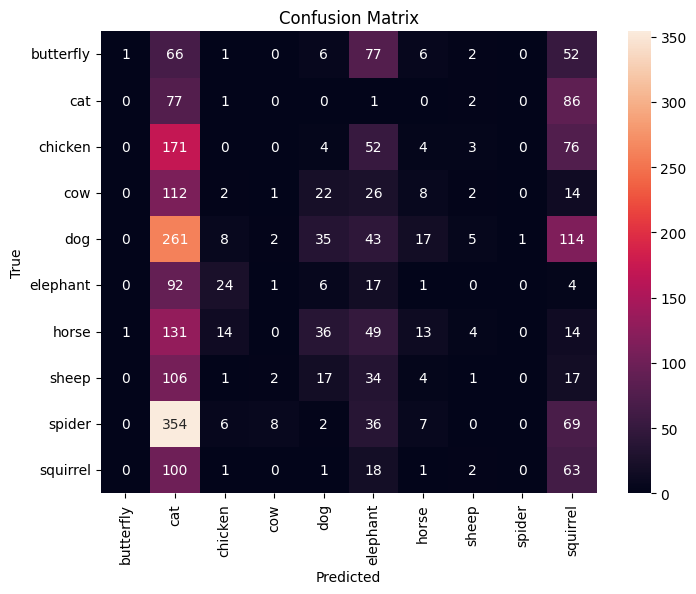

In [12]:
# try what happens if we don't train the model at all
mobnet2_small_report = print_evaluation(mobnet2_small,ds_test_mobnet,test_df,model_id='mobnet2_small_notraining',lr=LR,epochs=EPOCHS,batchsize=BATCH_SIZE)

Pretty random...

Now run 15 training epochs and evaluate:

Epoch 1/15


2025-06-13 09:22:11.513179: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6332', 32 bytes spill stores, 32 bytes spill loads

2025-06-13 09:22:11.533767: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6332', 36 bytes spill stores, 40 bytes spill loads



569/573 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7836 - loss: 0.6718

2025-06-13 09:22:19.657254: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4077', 4 bytes spill stores, 4 bytes spill loads



573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7842 - loss: 0.6702

2025-06-13 09:22:26.055087: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1169', 12 bytes spill stores, 12 bytes spill loads

2025-06-13 09:22:26.133027: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1169', 192 bytes spill stores, 192 bytes spill loads



573/573 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.7843 - loss: 0.6698 - val_accuracy: 0.9433 - val_loss: 0.1975
Epoch 2/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9049 - loss: 0.2875 - val_accuracy: 0.9505 - val_loss: 0.1653
Epoch 3/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9163 - loss: 0.2436 - val_accuracy: 0.9469 - val_loss: 0.1747
Epoch 4/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9282 - loss: 0.2172 - val_accuracy: 0.9515 - val_loss: 0.1633
Epoch 5/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9343 - loss: 0.1943 - val_accuracy: 0.9565 - val_loss: 0.1525
Epoch 6/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9441 - loss: 0.1672 - val_accuracy: 0.9565 - val_loss: 0.1529
Epoch 7/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9469 - loss: 0.1654 - val_accuracy: 0.9484 - val_loss: 0.1715
Epoch 8/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9516 - loss: 0.1469 - val_accurac

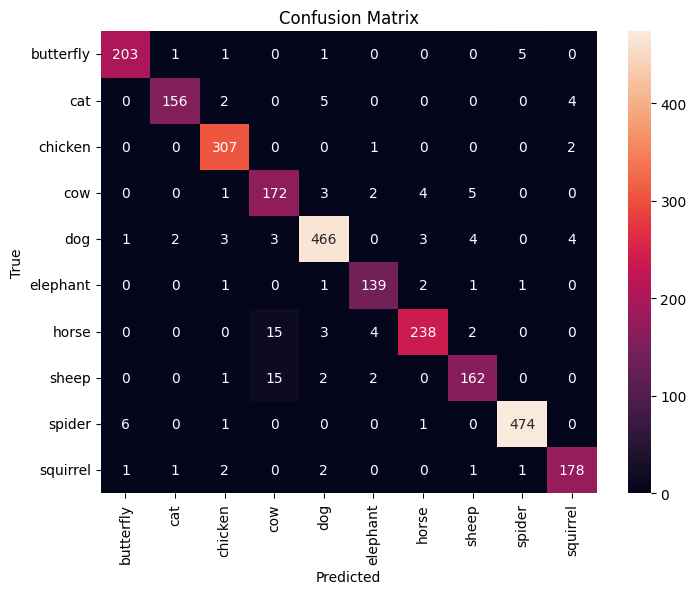

In [13]:

mobnet2_small_report = train_and_report(mobnet2_small,ds_train_mobnet,ds_val_mobnet,ds_test_mobnet,test_df,'mobnet2_small',LR,EPOCHS,BATCH_SIZE)

This result is impressively good already!

In [ ]:
#mobnet2_small.save(MODEL_PATH + 'mobnet2_anim_basic_2nd.keras')

In [15]:
del(mobnet2_small)
gc.collect()

49817

## Experimenting with slightly more dense layers (mobnet2_3dense)

In [16]:
LR = 0.0005
EPOCHS = 15

mobnet2_3dense = models.Sequential([
    base_mobnet2,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector
    layers.Dense(32, activation='relu'), # Fully connected layer to learn new patterns
    layers.Dropout(.2),
    layers.Dense(64, activation='relu'), # Fully connected layer to learn new patterns
    layers.Dropout(.3),
    layers.Dense(128, activation='relu'), # Fully connected layer to learn new patterns
    layers.Dropout(.2),
    layers.Dense(10, activation='softmax') # Output layer with 10 classes
])


specialAdam = keras.optimizers.Adam(learning_rate=LR)
mobnet2_3dense.compile(optimizer=specialAdam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mobnet2_3dense.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        40,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,310,698 (8.81 MB)

 Trainable params: 52,714 (205.91 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15


2025-06-13 09:25:33.287972: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5009', 4 bytes spill stores, 4 bytes spill loads

2025-06-13 09:25:33.345124: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5009', 148 bytes spill stores, 148 bytes spill loads



571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4765 - loss: 1.4714

2025-06-13 09:25:42.549882: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5009', 4 bytes spill stores, 4 bytes spill loads



573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4772 - loss: 1.4698

2025-06-13 09:25:48.950936: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1173', 192 bytes spill stores, 192 bytes spill loads



573/573 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.4775 - loss: 1.4689 - val_accuracy: 0.9429 - val_loss: 0.2128
Epoch 2/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.8257 - loss: 0.5454 - val_accuracy: 0.9486 - val_loss: 0.1761
Epoch 3/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.8598 - loss: 0.4647 - val_accuracy: 0.9473 - val_loss: 0.1859
Epoch 4/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.8783 - loss: 0.4127 - val_accuracy: 0.9519 - val_loss: 0.1640
Epoch 5/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8826 - loss: 0.3773 - val_accuracy: 0.9507 - val_loss: 0.1754
Epoch 6/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.8874 - loss: 0.3626 - val_accuracy: 0.9500 - val_loss: 0.1707
Epoch 7/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.8952 - loss: 0.3470 - val_accuracy: 0.9471 - val_loss: 0.1760
Epoch 8/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9002 - loss: 0.3150 - val_accurac

2025-06-13 09:28:38.858585: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1156', 172 bytes spill stores, 172 bytes spill loads



82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step
Accuracy: 0.9519
Precision: 0.9523
Recall: 0.9519
F1 Score: 0.9519
              precision    recall  f1-score   support

   butterfly       0.95      0.97      0.96       211
         cat       0.94      0.96      0.95       167
     chicken       0.97      0.98      0.98       310
         cow       0.91      0.88      0.89       187
         dog       0.97      0.93      0.95       486
    elephant       0.95      0.98      0.96       145
       horse       0.93      0.95      0.94       262
       sheep       0.87      0.92      0.90       182
      spider       0.99      0.98      0.98       482
    squirrel       0.96      0.95      0.95       186

    accuracy                           0.95      2618
   macro avg       0.94      0.95      0.95      2618
weighted avg       0.95      0.95      0.95      2618



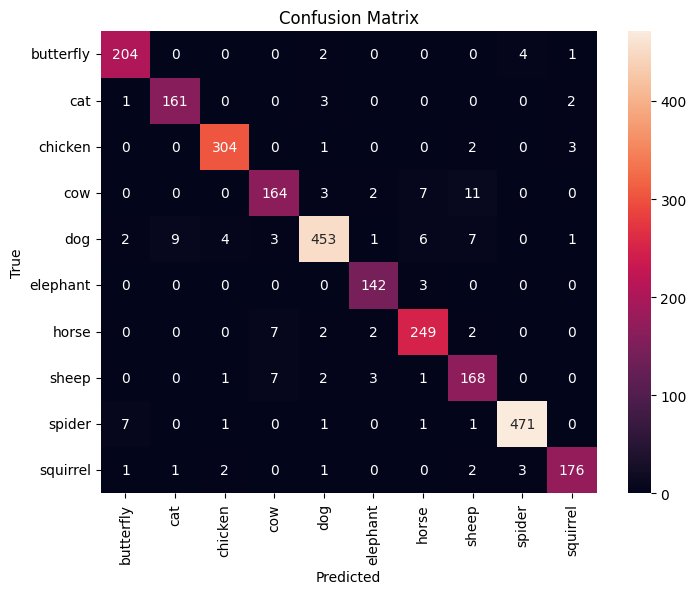

In [17]:
mobnet2_3dense_report = train_and_report(mobnet2_3dense,ds_train_mobnet,ds_val_mobnet,ds_test_mobnet,test_df,'mobnet2_3dense',LR,EPOCHS,BATCH_SIZE)

In [18]:
print_side_by_side(mobnet2_small_report,mobnet2_3dense_report)

              precision    recall  f1-score   support                  precision    recall  f1-score   support
                                                                
   butterfly       0.96      0.96      0.96       211       butterfly       0.95      0.97      0.96       211
         cat       0.97      0.93      0.95       167             cat       0.94      0.96      0.95       167
     chicken       0.96      0.99      0.98       310         chicken       0.97      0.98      0.98       310
         cow       0.84      0.92      0.88       187             cow       0.91      0.88      0.89       187
         dog       0.96      0.96      0.96       486             dog       0.97      0.93      0.95       486
    elephant       0.94      0.96      0.95       145        elephant       0.95      0.98      0.96       145
       horse       0.96      0.91      0.93       262           horse       0.93      0.95      0.94       262
       sheep       0.93      0.89      0.91    

The 3 extra layers were not very helpful (or would need more training to make any difference?). Training took longer and the result was not better.
Try once more with only two layers and decreasing number of neurons.

In [20]:
del(mobnet2_3dense)
gc.collect()

NameError: name 'mobnet2_3dense' is not defined

## mobnet2_2dense

In [21]:
LR = 0.0005
EPOCHS = 15

mobnet2_2dense = models.Sequential([
    base_mobnet2,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector
    layers.Dense(128, activation='relu'), # Fully connected layer to learn new patterns
    layers.Dense(32, activation='relu'), # Fully connected layer to learn new patterns
    layers.Dropout(.2),
    layers.Dense(10, activation='softmax') # Output layer with 10 classes
])


specialAdam = keras.optimizers.Adam(learning_rate=LR)
mobnet2_2dense.compile(optimizer=specialAdam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mobnet2_2dense.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,410 (9.26 MB)

 Trainable params: 168,426 (657.91 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.6955 - loss: 0.9617 - val_accuracy: 0.9421 - val_loss: 0.2035
Epoch 2/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.8813 - loss: 0.3838 - val_accuracy: 0.9511 - val_loss: 0.1654
Epoch 3/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.8959 - loss: 0.3353 - val_accuracy: 0.9544 - val_loss: 0.1565
Epoch 4/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9045 - loss: 0.3054 - val_accuracy: 0.9553 - val_loss: 0.1536
Epoch 5/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9108 - loss: 0.2714 - val_accuracy: 0.9494 - val_loss: 0.1716
Epoch 6/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9210 - loss: 0.2482 - val_accuracy: 0.9544 - val_loss: 0.1545
Epoch 7/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9230 - loss: 0.2387 - val_accuracy: 0.9568 - val_loss: 0.1529
Epoch 8/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9290 - loss: 0.2208 - 

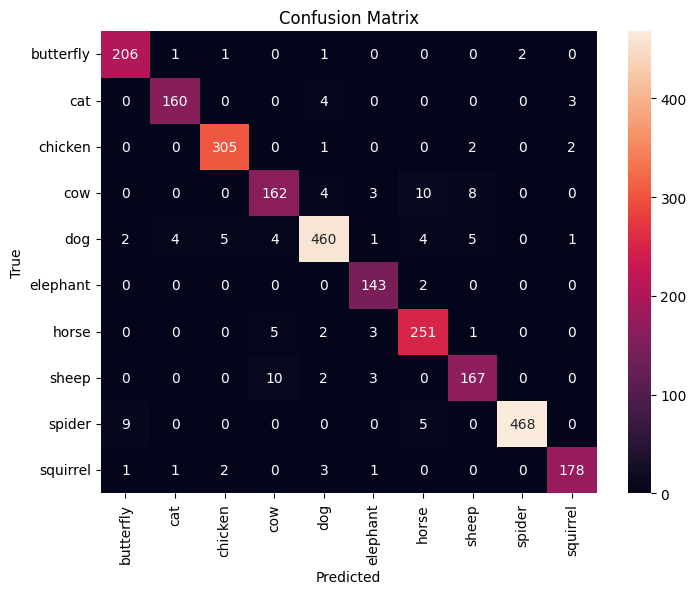

In [22]:

mobnet2_2dense_report = train_and_report(mobnet2_2dense,ds_train_mobnet,ds_val_mobnet,ds_test_mobnet,test_df,'mobnet2_2dense',LR,EPOCHS,BATCH_SIZE)

In [23]:
print_side_by_side(mobnet2_small_report,mobnet2_2dense_report)

              precision    recall  f1-score   support                  precision    recall  f1-score   support
                                                                
   butterfly       0.96      0.96      0.96       211       butterfly       0.94      0.98      0.96       211
         cat       0.97      0.93      0.95       167             cat       0.96      0.96      0.96       167
     chicken       0.96      0.99      0.98       310         chicken       0.97      0.98      0.98       310
         cow       0.84      0.92      0.88       187             cow       0.90      0.87      0.88       187
         dog       0.96      0.96      0.96       486             dog       0.96      0.95      0.96       486
    elephant       0.94      0.96      0.95       145        elephant       0.93      0.99      0.96       145
       horse       0.96      0.91      0.93       262           horse       0.92      0.96      0.94       262
       sheep       0.93      0.89      0.91    

Ok, adding more dense layers does not seem to help significantly (or at least not the way I am implementing it and at the number of epochs I'm running). So I can try unfreezing some layers next (although the result of the first model is quite respectable already).

In [55]:
K.clear_session()

## mobnet2_dense256

Test whether a single larger dense layer makes a difference.

In [56]:
LR = 0.0005
EPOCHS = 13

mobnet2_dense256 = models.Sequential([
    base_mobnet2,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector
    layers.Dense(256, activation='relu'), # Fully connected layer to learn new patterns
    layers.Dense(10, activation='softmax') # Output layer with 10 classes
])

mobnet2_dense256.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Epoch 1/13
573/573 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.7960 - loss: 0.6481 - val_accuracy: 0.9458 - val_loss: 0.1874
Epoch 2/13
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9057 - loss: 0.2882 - val_accuracy: 0.9488 - val_loss: 0.1739
Epoch 3/13
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9210 - loss: 0.2392 - val_accuracy: 0.9446 - val_loss: 0.1762
Epoch 4/13
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9279 - loss: 0.2237 - val_accuracy: 0.9498 - val_loss: 0.1666
Epoch 5/13
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9386 - loss: 0.1825 - val_accuracy: 0.9580 - val_loss: 0.1445
Epoch 6/13
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9471 - loss: 0.1604 - val_accuracy: 0.9532 - val_loss: 0.1632
Epoch 7/13
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9542 - loss: 0.1386 - val_accuracy: 0.9526 - val_loss: 0.1518
Epoch 8/13
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9580 - loss: 0.1315 - 

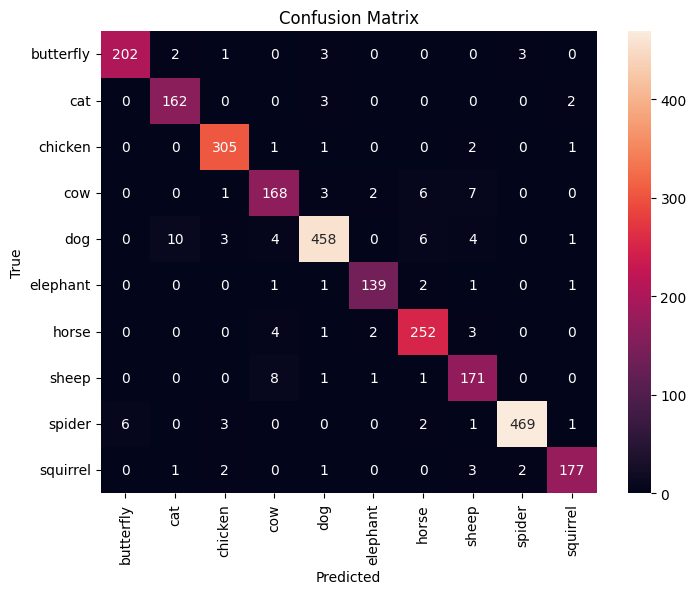

In [57]:
mobnet2_dense256_hist, mobnet2_dense256_report = train_and_report(mobnet2_dense256,ds_train_mobnet,ds_val_mobnet,ds_test_mobnet,test_df,'mobnet2_dense256',LR,EPOCHS,BATCH_SIZE,returnhist=True)

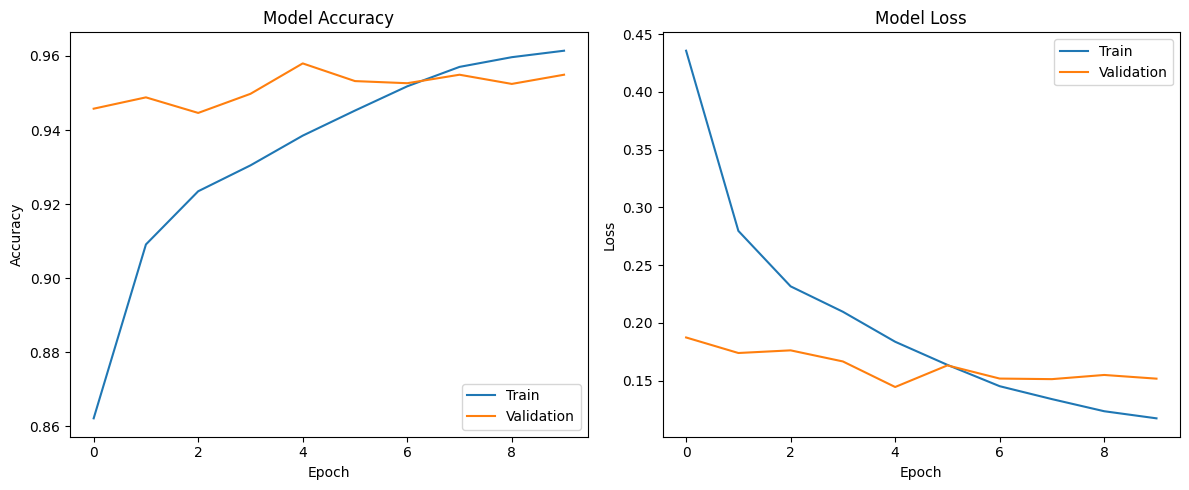

In [ ]:
plothist(mobnet2_dense256_hist,export='assets/mobnet2_dense256.png')

# mobnet2_dense256.save(MODEL_PATH + 'mobnet2_dense256_base.keras')

This is actually also a rather promising result. I shall try fine-tuning this model in addition to the one with a 128-neurons dense layer.

In [61]:
K.clear_session()

## Intermediate overview

In [60]:
pd.read_csv(RESULT_CSV).sort_values(by='accuracy',ascending=False)

,time,model_id,learning_rate,epochs,batchsize,acc_train,acc_val,accuracy,precision,recall,f1_score
30,2025-06-13 13:11:47,effet2S_small_finetune,0.00001,35,32,0.988264,0.982238,0.976700,0.976716,0.976700,0.976686
29,2025-06-13 12:42:30,effnet2S_small,0.00050,12,32,0.974127,0.979947,0.974790,0.975016,0.974790,0.974840
31,2025-06-13 13:29:15,mobnet2_dense256,0.00050,13,32,0.957696,0.956264,0.961421,0.961458,0.961421,0.961417
25,2025-06-13 11:11:27,mobnet2_small_tune20_15epochs,0.00010,10,32,0.965884,0.957792,0.960275,0.960530,0.960275,0.960342
28,2025-06-13 12:16:11,resnet2_small_finetune,0.00001,30,32,0.993832,0.966005,0.959129,0.959845,0.959129,0.959364
24,2025-06-13 11:08:30,mobnet2_small_tune20,0.00010,5,32,0.960426,0.958747,0.957601,0.957620,0.957601,0.957554
23,2025-06-13 11:05:52,mobnet2_small_tune20,0.00001,5,32,0.953603,0.956837,0.956837,0.957314,0.956837,0.956983
32,2025-06-13 13:39:37,mobnet2_dense256,0.00050,13,32,0.961408,0.954927,0.956073,0.956636,0.956073,0.956192
19,2025-06-13 09:34:45,mobnet2_2dense,0.00050,15,32,0.941103,0.955309,0.954927,0.955256,0.954927,0.954924
17,2025-06-13 09:24:23,mobnet2_small,0.00070,15,32,0.956277,0.953973,0.953018,0.953837,0.953018,0.953139


## Tuning

### mobnet2_small: fine-tuning

I am now going to try fine-tuning the smallest version of the model by unfreezing some layers of the base model and continuing training on them with a very small learning rate.

In [9]:
# reload mobnet2_small
mobnet2_small = keras.models.load_model(MODEL_PATH + 'mobnet2_anim_basic_2nd.keras')

In [10]:
# Unfreeze last layers of base model for fine-tuning
base_mobnet2.trainable = True

# Freeze all layers except the last N (e.g., last 20 layers)
fine_tune_at = len(base_mobnet2.layers) - 20
for layer in base_mobnet2.layers[:fine_tune_at]:
    layer.trainable = False

In [13]:
LR = 1e-4
finetune_epochs = 10

mobnet2_small.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

Epoch 1/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9603 - loss: 0.1215 - val_accuracy: 0.9591 - val_loss: 0.1429
Epoch 2/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9668 - loss: 0.1061 - val_accuracy: 0.9576 - val_loss: 0.1479
Epoch 3/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9657 - loss: 0.1067 - val_accuracy: 0.9580 - val_loss: 0.1441
Epoch 4/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9663 - loss: 0.1081 - val_accuracy: 0.9570 - val_loss: 0.1460
Epoch 5/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9688 - loss: 0.1009 - val_accuracy: 0.9565 - val_loss: 0.1490
Epoch 6/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9677 - loss: 0.1005 - val_accuracy: 0.9578 - val_loss: 0.1524
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
Accuracy: 0.9603
Precision: 0.9605
Recall: 0.9603
F1 Score: 0.9603
              precision    recall  f1-score   support

   butterfly       0.97      0.96      0.96       211
    

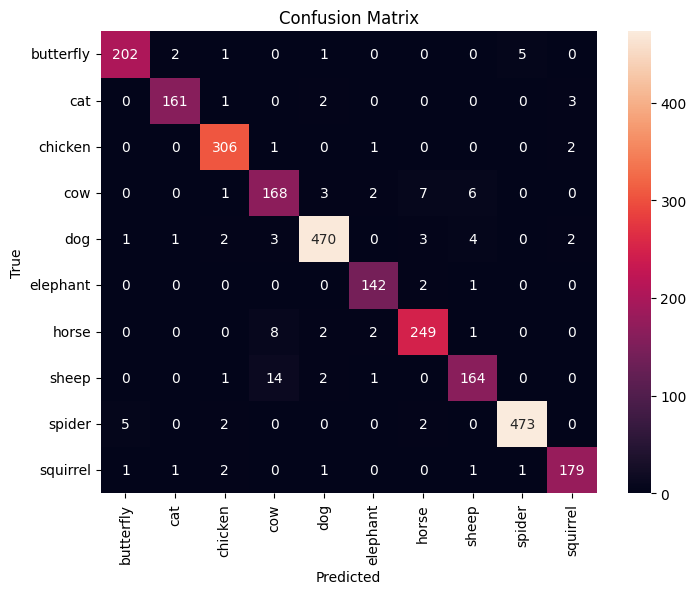

In [14]:
mobnet2_small_report = train_and_report(mobnet2_small,ds_train_mobnet,ds_val_mobnet,ds_test_mobnet,test_df,'mobnet2_small_tune20_15epochs',LR,finetune_epochs,BATCH_SIZE)


This is a very good model already. There's only one category with an F1 score <.9, namely cow (due to a precision slightly under .9). All other categories have scores of .9 and up for both precision and recall.

In [ ]:
# saving finetuned model
# mobnet2_small.save(MODEL_PATH + 'mobnet2_anim_small_finetuned.keras')

In [ ]:
K.clear_session()

### mobnet_dense256

In [62]:
mobnet2_dense256 = keras.models.load_model(MODEL_PATH + 'mobnet2_dense256_base.keras')

In [63]:
# Unfreeze last layers of base model for fine-tuning
base_mobnet2.trainable = True

# Freeze all layers except the last N (e.g., last 20 layers)
fine_tune_at = len(base_mobnet2.layers) - 25
for layer in base_mobnet2.layers[:fine_tune_at]:
    layer.trainable = False

In [65]:
LR = 1e-5
EPOCHS = 30
PATIENCE = 10

mobnet2_dense256.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

In [ ]:
mobnet_dense256.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,249,508 (12.40 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 661,018 (2.52 MB)

Epoch 1/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9544 - loss: 0.1452 - val_accuracy: 0.9589 - val_loss: 0.1397
Epoch 2/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9583 - loss: 0.1324 - val_accuracy: 0.9599 - val_loss: 0.1390
Epoch 3/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9616 - loss: 0.1275 - val_accuracy: 0.9599 - val_loss: 0.1386
Epoch 4/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9589 - loss: 0.1250 - val_accuracy: 0.9601 - val_loss: 0.1382
Epoch 5/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9586 - loss: 0.1286 - val_accuracy: 0.9595 - val_loss: 0.1382
Epoch 6/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9622 - loss: 0.1226 - val_accuracy: 0.9597 - val_loss: 0.1389
Epoch 7/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9627 - loss: 0.1251 - val_accuracy: 0.9591 - val_loss: 0.1391
Epoch 8/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9631 - loss: 0.1215 - 

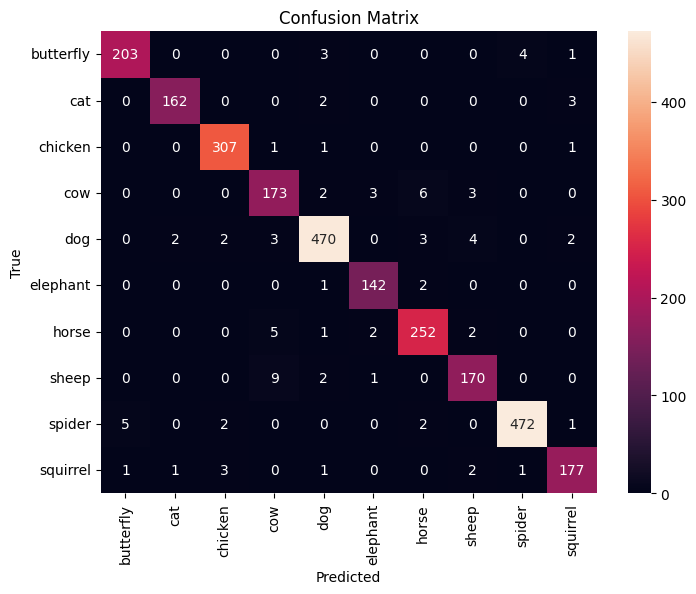

In [66]:
mobnet2_dense256_finetune_hist, mobnet_dense256_finetune_report = train_and_report(mobnet2_dense256,
                                                                              ds_train_mobnet,
                                                                              ds_val_mobnet,
                                                                              ds_test_mobnet,
                                                                              test_df,
                                                                              'mobnet2_dense256_finetune',
                                                                              LR,EPOCHS,BATCH_SIZE,early_patience=PATIENCE,returnhist=True)

# append the history
for key in mobnet2_dense256_finetune_hist.history:
    mobnet2_dense256_hist.history[key] += mobnet2_dense256_finetune_hist.history[key] 

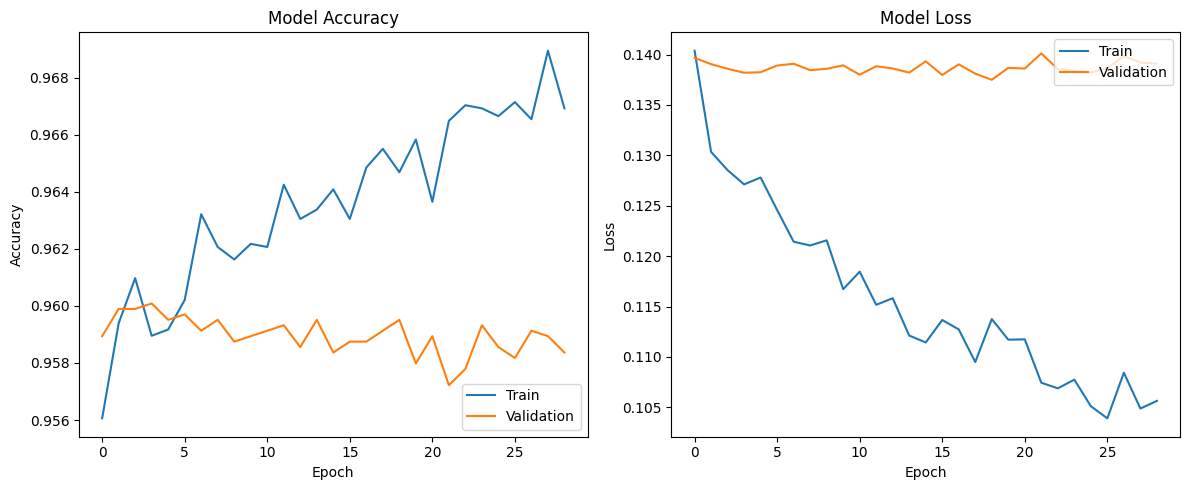

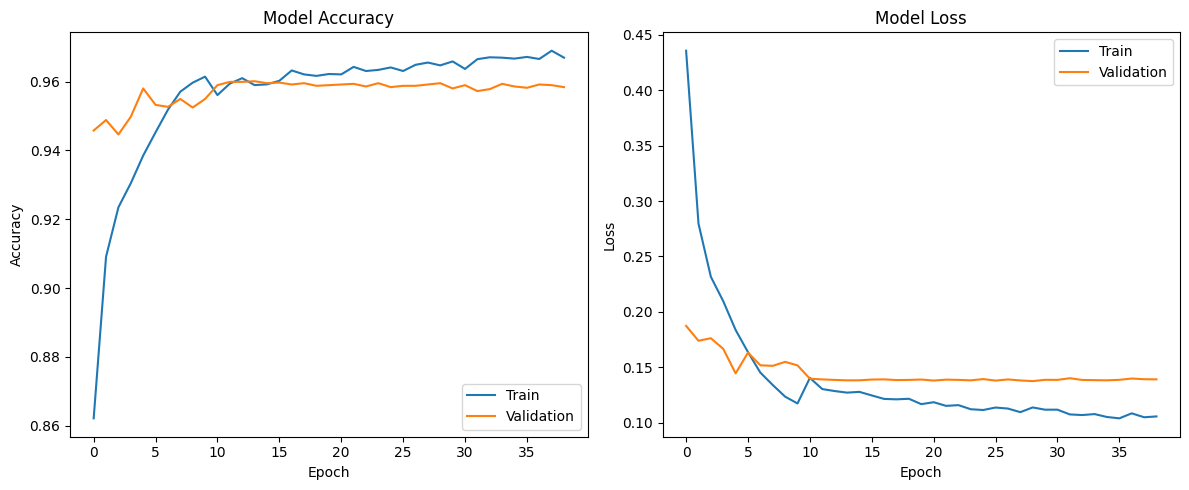

In [67]:
plothist(mobnet2_dense256_finetune_hist,export='assets/mobnet2_dense256_finetunedonly.png')
plothist(mobnet2_dense256_hist,export='assets/mobnet2_dense256_finetuned_full.png')

# uncomment as required
# mobnet2_dense256.save(MODEL_PATH + 'mobnet2_dense256_finetuned.keras')

The fine-tuning led to some slight improvement, although not by a lot (about .004 increase in test accuracy). F1-scores for all categories are over .9 (and only sheep and cow are not over .95).

## Intermediate overview

In [68]:
pd.read_csv(RESULT_CSV).sort_values(by='accuracy',ascending=False)

,time,model_id,learning_rate,epochs,batchsize,acc_train,acc_val,accuracy,precision,recall,f1_score
30,2025-06-13 13:11:47,effet2S_small_finetune,0.00001,35,32,0.988264,0.982238,0.976700,0.976716,0.976700,0.976686
29,2025-06-13 12:42:30,effnet2S_small,0.00050,12,32,0.974127,0.979947,0.974790,0.975016,0.974790,0.974840
33,2025-06-13 13:54:46,mobnet2_dense256_finetune,0.00001,30,32,0.966921,0.958365,0.965623,0.965777,0.965623,0.965667
31,2025-06-13 13:29:15,mobnet2_dense256,0.00050,13,32,0.957696,0.956264,0.961421,0.961458,0.961421,0.961417
25,2025-06-13 11:11:27,mobnet2_small_tune20_15epochs,0.00010,10,32,0.965884,0.957792,0.960275,0.960530,0.960275,0.960342
28,2025-06-13 12:16:11,resnet2_small_finetune,0.00001,30,32,0.993832,0.966005,0.959129,0.959845,0.959129,0.959364
24,2025-06-13 11:08:30,mobnet2_small_tune20,0.00010,5,32,0.960426,0.958747,0.957601,0.957620,0.957601,0.957554
23,2025-06-13 11:05:52,mobnet2_small_tune20,0.00001,5,32,0.953603,0.956837,0.956837,0.957314,0.956837,0.956983
32,2025-06-13 13:39:37,mobnet2_dense256,0.00050,13,32,0.961408,0.954927,0.956073,0.956636,0.956073,0.956192
19,2025-06-13 09:34:45,mobnet2_2dense,0.00050,15,32,0.941103,0.955309,0.954927,0.955256,0.954927,0.954924


# ResNet50V2

For Resnet50-v2, I should be able to reuse the datasets created for mobilenet, since the sole preprocessing step for the input is also a scaling to [-1;1]. 

## Base model

In [8]:
# Build transfer learning model
base_resnet2 = resnet_v2.ResNet50V2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_resnet2.trainable = False  # Freeze base

In [9]:
LR = 0.0007
EPOCHS = 10

resnet2_small = models.Sequential([
    base_resnet2,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector
    layers.Dense(128, activation='relu'), # Fully connected layer to learn new patterns
    layers.Dense(10, activation='softmax') # Output layer with 10 classes
])


resnet2_small.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet2_small.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,828,362 (90.90 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/15


I0000 00:00:1749808340.024527  671325 service.cc:146] XLA service 0x7f0c80002b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749808340.024551  671325 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-06-13 11:52:20.138461: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-13 11:52:20.728075: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-06-13 11:52:21.908513: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7737', 36 bytes spill stores, 40 bytes spill loads

2025-06-13 11:52:21.919506: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in

  8/573 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.1299 - loss: 2.7403

I0000 00:00:1749808344.880807  671325 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8006 - loss: 0.6385

2025-06-13 11:52:45.191672: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1504', 12 bytes spill stores, 12 bytes spill loads

2025-06-13 11:52:45.204641: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1504', 176 bytes spill stores, 176 bytes spill loads



573/573 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.8007 - loss: 0.6381 - val_accuracy: 0.9475 - val_loss: 0.1777
Epoch 2/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9183 - loss: 0.2518 - val_accuracy: 0.9538 - val_loss: 0.1589
Epoch 3/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9312 - loss: 0.2067 - val_accuracy: 0.9446 - val_loss: 0.1897
Epoch 4/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9427 - loss: 0.1777 - val_accuracy: 0.9482 - val_loss: 0.1796
Epoch 5/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9490 - loss: 0.1623 - val_accuracy: 0.9544 - val_loss: 0.1706
Epoch 6/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9557 - loss: 0.1332 - val_accuracy: 0.9553 - val_loss: 0.1744
Epoch 7/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9577 - loss: 0.1274 - val_accuracy: 0.9517 - val_loss: 0.1863
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

2025-06-13 11:54:45.369515: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1487', 176 bytes spill stores, 176 bytes spill loads

2025-06-13 11:54:45.406014: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1487', 28 bytes spill stores, 28 bytes spill loads



82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step
Accuracy: 0.9458
Precision: 0.9462
Recall: 0.9458
F1 Score: 0.9457
              precision    recall  f1-score   support

   butterfly       0.95      0.98      0.96       211
         cat       0.90      0.96      0.93       167
     chicken       0.96      0.97      0.97       310
         cow       0.90      0.87      0.89       187
         dog       0.96      0.91      0.93       486
    elephant       0.97      0.97      0.97       145
       horse       0.91      0.95      0.93       262
       sheep       0.90      0.91      0.90       182
      spider       0.99      0.98      0.98       482
    squirrel       0.93      0.97      0.95       186

    accuracy                           0.95      2618
   macro avg       0.94      0.95      0.94      2618
weighted avg       0.95      0.95      0.95      2618



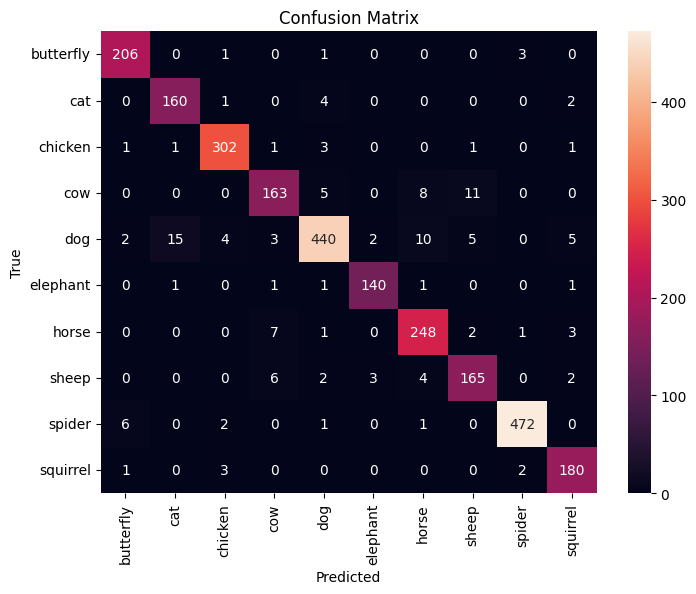

In [10]:
resnet2_small_hist, resnet2_small_report = train_and_report(resnet2_small,ds_train_mobnet,ds_val_mobnet,ds_test_mobnet,test_df,'resnet2_small',LR,EPOCHS,BATCH_SIZE,returnhist=True)

Training stopped after 5 iterations. Decent result, slightly worse than MobileNet_v2 above. Now that I am exporting the history, I can also plot the accuracy and loss throughout the training:

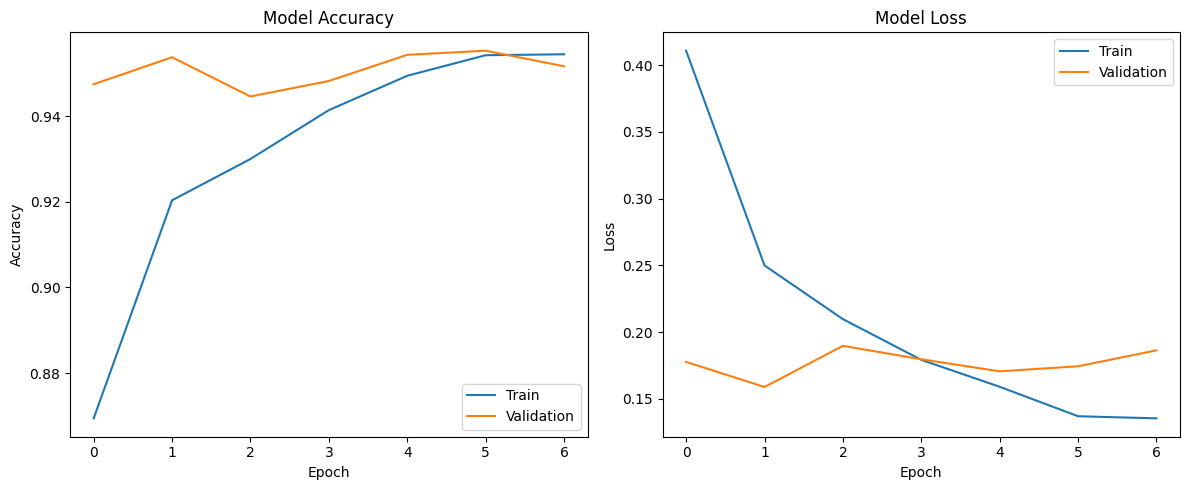

In [20]:
plothist(resnet2_small_hist,export='assets/resnet2_small_basetrain.png')

## Tuning ResNet

In [12]:
# Unfreeze last layers of base model for fine-tuning
base_resnet2.trainable = True

# Freeze all layers except the last N (e.g., last 20 layers)
fine_tune_at = len(base_resnet2.layers) - 20
for layer in base_resnet2.layers[:fine_tune_at]:
    layer.trainable = False

In [18]:
LR = 1e-5
EPOCHS = 30
PATIENCE = 10

resnet2_small.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

Epoch 1/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.9666 - loss: 0.1108 - val_accuracy: 0.9597 - val_loss: 0.1482
Epoch 2/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9714 - loss: 0.0917 - val_accuracy: 0.9610 - val_loss: 0.1433
Epoch 3/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9774 - loss: 0.0780 - val_accuracy: 0.9622 - val_loss: 0.1386
Epoch 4/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9819 - loss: 0.0665 - val_accuracy: 0.9618 - val_loss: 0.1404
Epoch 5/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9815 - loss: 0.0628 - val_accuracy: 0.9641 - val_loss: 0.1383
Epoch 6/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9846 - loss: 0.0556 - val_accuracy: 0.9639 - val_loss: 0.1355
Epoch 7/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9865 - loss: 0.0465 - val_accuracy: 0.9649 - val_loss: 0.1367
Epoch 8/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9869 - loss: 0.0463 - 

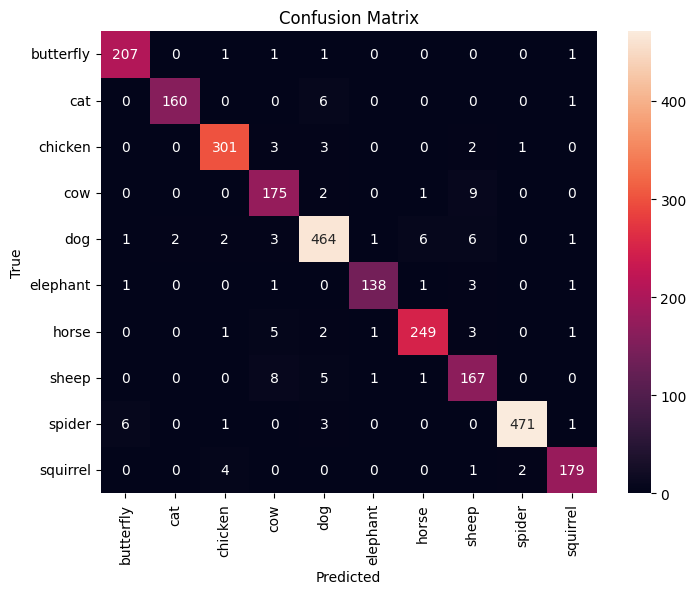

In [19]:
resnet2_small_finetune_hist, resnet2_small_finetune_report = train_and_report(resnet2_small,ds_train_mobnet,ds_val_mobnet,ds_test_mobnet,test_df,'resnet2_small_finetune',LR,EPOCHS,BATCH_SIZE,early_patience=PATIENCE,returnhist=True)

Ok, the lower learning rate actually helped improve the model performance through additional epochs of tuning. Let's plot the training performance and then save the model, too.

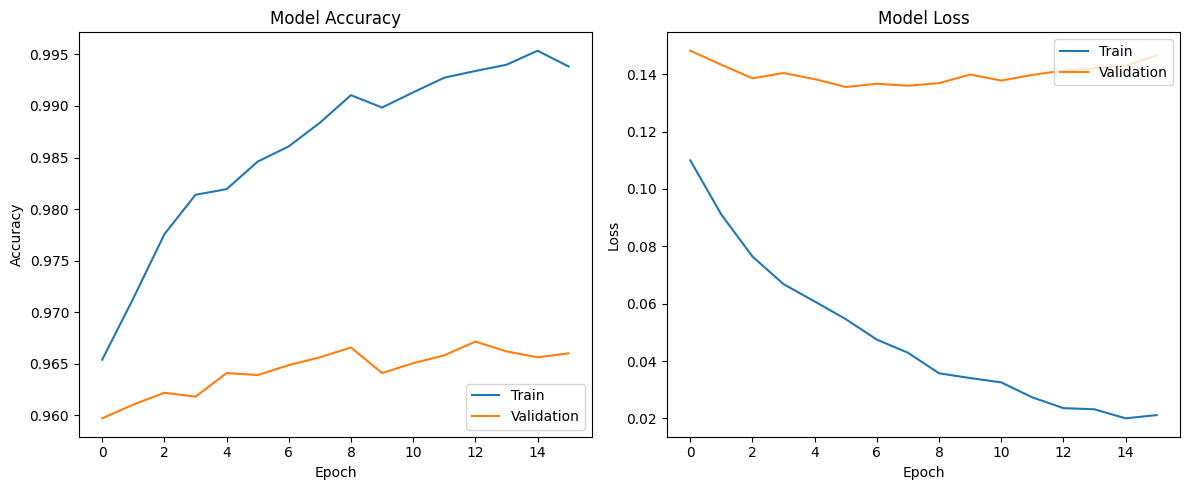

In [21]:
plothist(resnet2_small_finetune_hist,export='assets/resnet2_small_finetune.png')

In [ ]:
# uncomment if needed to save anew
# resnet2_small.save(MODEL_PATH + 'resnet2_small_finetuned.keras')

In [ ]:
K.clear_session()

# EfficientNetV2S

I am also going to try out EfficientNetV2S.

It actually expects the input data raw, i.e. as values in the intervall [0;255]. I hance create new datasets applying the (empty) preprocessing from `efficientnet_v2.preprocess_input`. Alternatively, it would also be possible to set `preprocessing=False` when importing the model and use the datasets preprocessed for mobilenet_v2 to [-1;1].

In [30]:
# creating datasets for validation and test

ds_train_eff = mk_tf_dataset(train_df,augment=True,preprocess_fn=efficient_preprocess)        
ds_val_eff = mk_tf_dataset(val_df,shuffle=False,preprocess_fn=efficient_preprocess)
ds_test_eff = mk_tf_dataset(test_df,shuffle=False,preprocess_fn=efficient_preprocess)

## Base model

In [31]:
# Build transfer learning model
base_effnet2S = efficientnet_v2.EfficientNetV2S(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_effnet2S.trainable = False  # Freeze base

In [32]:
# try out a slightly larger dense layer here

LR = 0.0005
EPOCHS = 12

effnet2S_small = models.Sequential([
    base_effnet2S,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector
    layers.Dense(256, activation='relu'), # Fully connected layer to learn new patterns
    layers.Dense(10, activation='softmax') # Output layer with 10 classes
])


effnet2S_small.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
effnet2S_small.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-s (Functional)   │ (None, 7, 7, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,661,866 (78.82 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

Epoch 1/12


2025-06-13 12:36:58.212096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:33: Filling up shuffle buffer (this may take a while): 8804 of 18320
2025-06-13 12:37:09.159731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


573/573 ━━━━━━━━━━━━━━━━━━━━ 101s 82ms/step - accuracy: 0.8583 - loss: 0.5329 - val_accuracy: 0.9756 - val_loss: 0.0953
Epoch 2/12
573/573 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.9373 - loss: 0.2021 - val_accuracy: 0.9767 - val_loss: 0.0905
Epoch 3/12
573/573 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9430 - loss: 0.1800 - val_accuracy: 0.9761 - val_loss: 0.0878
Epoch 4/12
573/573 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.9551 - loss: 0.1426 - val_accuracy: 0.9792 - val_loss: 0.0851
Epoch 5/12
573/573 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9568 - loss: 0.1326 - val_accuracy: 0.9784 - val_loss: 0.0825
Epoch 6/12
573/573 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9622 - loss: 0.1174 - val_accuracy: 0.9780 - val_loss: 0.0848
Epoch 7/12
573/573 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9636 - loss: 0.1119 - val_accuracy: 0.9798 - val_loss: 0.0828
Epoch 8/12
573/573 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9619 - loss: 0.1169 - val_accura

2025-06-13 12:42:26.188909: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4215', 28 bytes spill stores, 28 bytes spill loads

2025-06-13 12:42:26.351132: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4215', 172 bytes spill stores, 172 bytes spill loads



82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step
Accuracy: 0.9748
Precision: 0.9750
Recall: 0.9748
F1 Score: 0.9748
              precision    recall  f1-score   support

   butterfly       0.98      0.97      0.98       211
         cat       0.98      0.98      0.98       167
     chicken       0.98      0.99      0.98       310
         cow       0.96      0.95      0.95       187
         dog       0.99      0.98      0.98       486
    elephant       0.98      0.97      0.98       145
       horse       0.95      0.98      0.97       262
       sheep       0.92      0.95      0.93       182
      spider       1.00      0.98      0.99       482
    squirrel       0.97      0.98      0.98       186

    accuracy                           0.97      2618
   macro avg       0.97      0.97      0.97      2618
weighted avg       0.98      0.97      0.97      2618



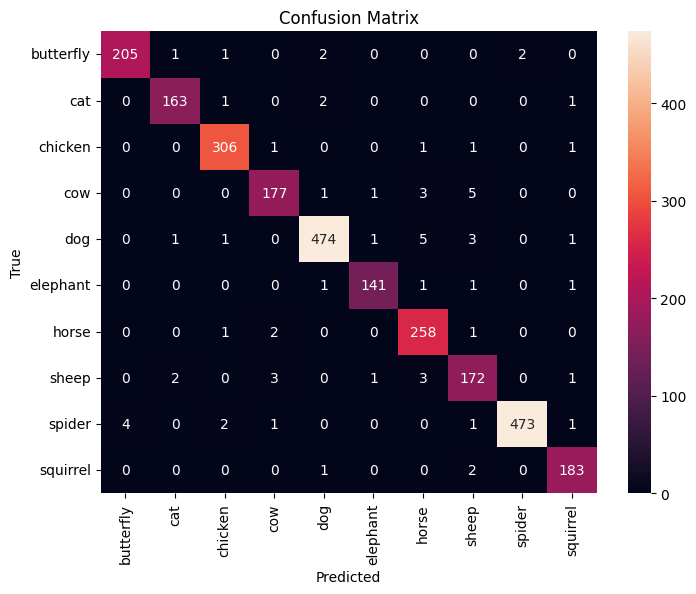

In [33]:
effnet2S_small_hist, effnet2S_small_report = train_and_report(effnet2S_small,ds_train_eff,ds_val_eff,ds_test_eff,test_df,'effnet2S_small',LR,EPOCHS,BATCH_SIZE,returnhist=True)

This is a very impressive result, even though the training time was a bit longer. I wonder to what extent the bigger dense layer may have played into this (maybe I'll experiment with one of the other models), but great starting point for further fine-tuning.

But first to plot the history and save this model.

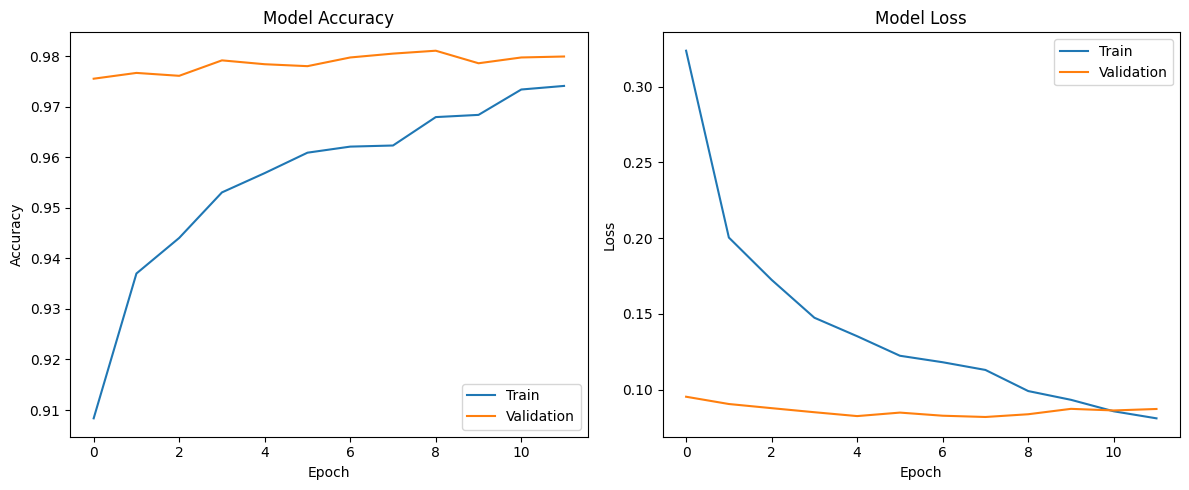

In [34]:
plothist(effnet2S_small_hist,export='assets/effnetv2s_small_base.png')

# uncomment as required
#effnet2S_small.save(MODEL_PATH + 'effnetv2s_small.keras')

## Tuning

In [36]:
# Unfreeze last layers of base model for fine-tuning
base_effnet2S.trainable = True

# Freeze all layers except the last N 
# try unfreezing 30
fine_tune_at = len(base_effnet2S.layers) - 30
for layer in base_effnet2S.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
LR = 1e-5
EPOCHS = 35
PATIENCE = 10

effnet2S_small.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

Epoch 1/35
570/573 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9597 - loss: 0.1320

2025-06-13 12:58:42.626972: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25214', 8 bytes spill stores, 8 bytes spill loads



573/573 ━━━━━━━━━━━━━━━━━━━━ 90s 82ms/step - accuracy: 0.9598 - loss: 0.1320 - val_accuracy: 0.9771 - val_loss: 0.0862
Epoch 2/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.9698 - loss: 0.1002 - val_accuracy: 0.9790 - val_loss: 0.0837
Epoch 3/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.9686 - loss: 0.1001 - val_accuracy: 0.9796 - val_loss: 0.0824
Epoch 4/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9727 - loss: 0.0921 - val_accuracy: 0.9790 - val_loss: 0.0816
Epoch 5/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.9709 - loss: 0.0925 - val_accuracy: 0.9788 - val_loss: 0.0807
Epoch 6/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.9738 - loss: 0.0908 - val_accuracy: 0.9796 - val_loss: 0.0801
Epoch 7/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.9734 - loss: 0.0877 - val_accuracy: 0.9807 - val_loss: 0.0792
Epoch 8/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.9765 - loss: 0.0755 - val_accurac

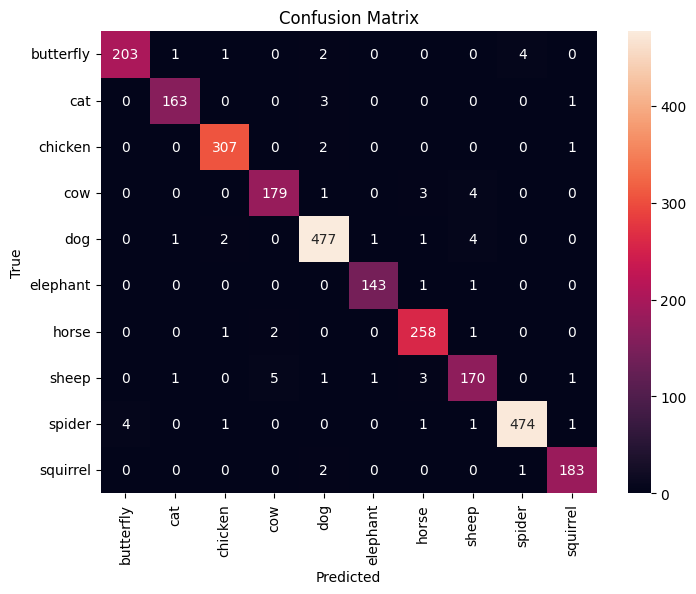

In [38]:
effnet2S_small_finetune_hist, effnet2S_small_finetune_report = train_and_report(effnet2S_small,
                                                                              ds_train_eff,
                                                                              ds_val_eff,
                                                                              ds_test_eff,
                                                                              test_df,
                                                                              'effet2S_small_finetune',
                                                                              LR,EPOCHS,BATCH_SIZE,early_patience=PATIENCE,returnhist=True)

# append the history
for key in effnet2S_small_finetune_hist.history:
    effnet2S_small_hist.history[key] += effnet2S_small_finetune_hist.history[key] 


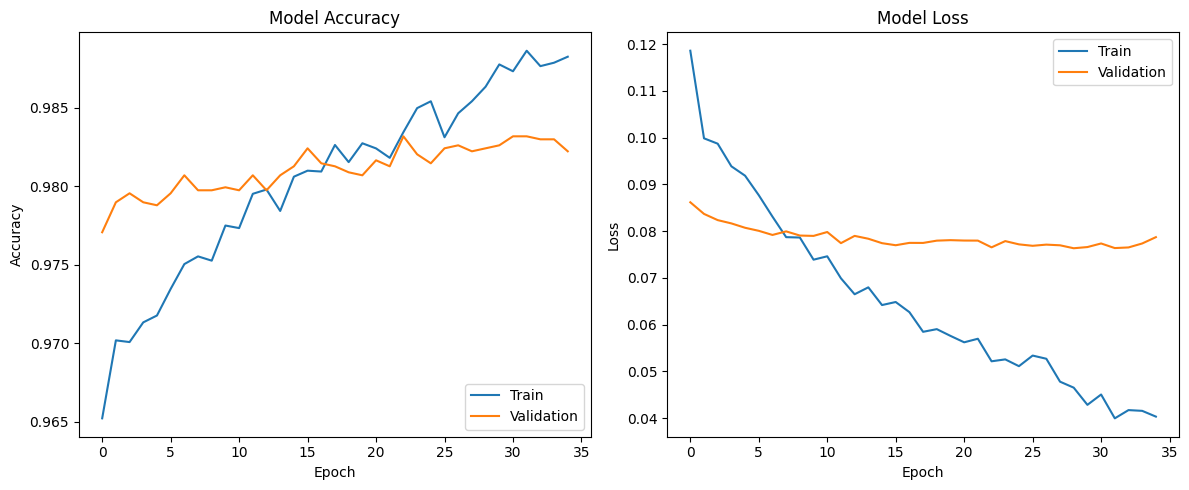

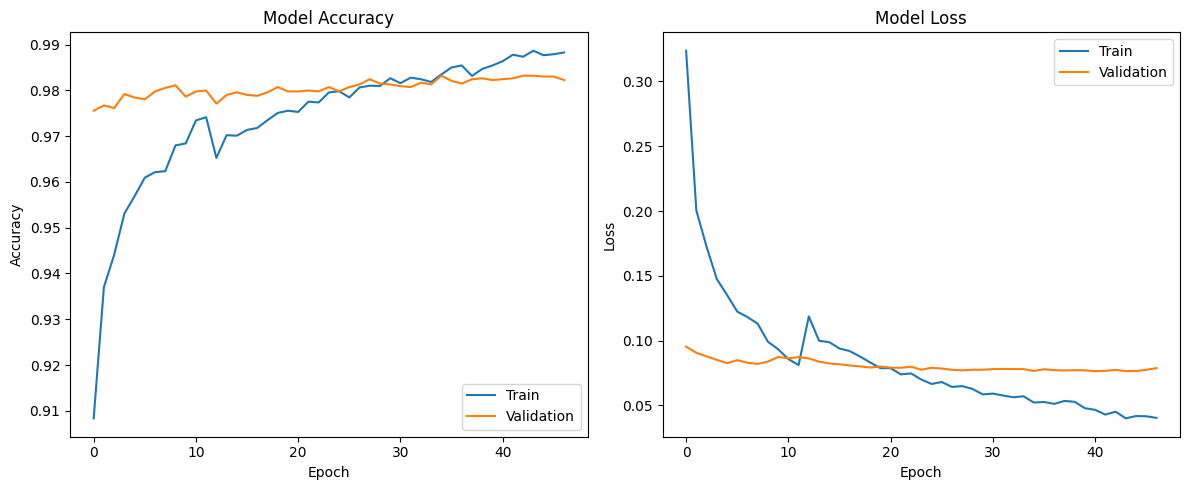

In [39]:
plothist(effnet2S_small_finetune_hist,export='assets/effnetv2s_small_finetunedonly.png')
plothist(effnet2S_small_hist,export='assets/effnetv2s_small_finetuned_full.png')

# uncomment as required
# effnet2S_small.save(MODEL_PATH + 'effnetv2s_small_finetuned.keras')

This is a really strong performance with a total accuracy of .9767 and only one category (sheep) had an F1-score under .95 (specifically 0.94). More training would probably increase the risk of overfitting (unless unfreezing more layers).

# Full results overview

In [70]:
results = pd.read_csv(RESULT_CSV).sort_values(by='accuracy',ascending=False)
results

,time,model_id,learning_rate,epochs,batchsize,acc_train,acc_val,accuracy,precision,recall,f1_score
30,2025-06-13 13:11:47,effet2S_small_finetune,0.00001,35,32,0.988264,0.982238,0.976700,0.976716,0.976700,0.976686
29,2025-06-13 12:42:30,effnet2S_small,0.00050,12,32,0.974127,0.979947,0.974790,0.975016,0.974790,0.974840
33,2025-06-13 13:54:46,mobnet2_dense256_finetune,0.00001,30,32,0.966921,0.958365,0.965623,0.965777,0.965623,0.965667
31,2025-06-13 13:29:15,mobnet2_dense256,0.00050,13,32,0.957696,0.956264,0.961421,0.961458,0.961421,0.961417
25,2025-06-13 11:11:27,mobnet2_small_tune20_15epochs,0.00010,10,32,0.965884,0.957792,0.960275,0.960530,0.960275,0.960342
28,2025-06-13 12:16:11,resnet2_small_finetune,0.00001,30,32,0.993832,0.966005,0.959129,0.959845,0.959129,0.959364
24,2025-06-13 11:08:30,mobnet2_small_tune20,0.00010,5,32,0.960426,0.958747,0.957601,0.957620,0.957601,0.957554
23,2025-06-13 11:05:52,mobnet2_small_tune20,0.00001,5,32,0.953603,0.956837,0.956837,0.957314,0.956837,0.956983
32,2025-06-13 13:39:37,mobnet2_dense256,0.00050,13,32,0.961408,0.954927,0.956073,0.956636,0.956073,0.956192
19,2025-06-13 09:34:45,mobnet2_2dense,0.00050,15,32,0.941103,0.955309,0.954927,0.955256,0.954927,0.954924


EfficientNetV2S is clearly the strongest pre-trained model among the ones tested. Tuning by retraining the last 30 layers led to a marginal improvement of test accuracy (`effet2S_small_finetune`).

In terms of training time/computational efficiency the runner-up `mobnet2_dense256` is a strong contender. At an accuracy of 0.9656 the fine-tuned version has only about 0.011 difference in accuracy from the tuned version of the EfficiencyNetV2S model, while being much faster to train and also much smaller.

Size of `effnet2s_small_finetune`: 20,661,866 (78.82 MB)
Size of `mobnet_dense256_finetune`: 3,249,508 (12.40 MB)

Overall, the models with a 256-neurons strong dense layer (i.e. the mobnet version with 256 and the EfficientNetModel) instead of 128 are slightly outperforming the ones with 128-neuron dense layers. Additional dense layers did not offer any noticable benefits in my (limited) experimentation.

Compared to the manually built and trained convolutional neural networks, the performance is expectedly considerably improved. 

In [79]:
results_lt = results.copy()
results_lt['model_id'] = results_lt['model_id'].str.replace('_','-')
print(results_lt[['model_id','learning_rate','epochs','acc_train','accuracy']].to_latex(index=False,float_format="%.5f"))

\begin{tabular}{lrrrr}
\toprule
model_id & learning_rate & epochs & acc_train & accuracy \\
\midrule
effet2S-small-finetune & 0.00001 & 35 & 0.98826 & 0.97670 \\
effnet2S-small & 0.00050 & 12 & 0.97413 & 0.97479 \\
mobnet2-dense256-finetune & 0.00001 & 30 & 0.96692 & 0.96562 \\
mobnet2-dense256 & 0.00050 & 13 & 0.95770 & 0.96142 \\
mobnet2-small-tune20-15epochs & 0.00010 & 10 & 0.96588 & 0.96028 \\
resnet2-small-finetune & 0.00001 & 30 & 0.99383 & 0.95913 \\
mobnet2-small-tune20 & 0.00010 & 5 & 0.96043 & 0.95760 \\
mobnet2-small-tune20 & 0.00001 & 5 & 0.95360 & 0.95684 \\
mobnet2-dense256 & 0.00050 & 13 & 0.96141 & 0.95607 \\
mobnet2-2dense & 0.00050 & 15 & 0.94110 & 0.95493 \\
mobnet2-small & 0.00070 & 15 & 0.95628 & 0.95302 \\
mobnet2-3dense & 0.00050 & 15 & 0.91332 & 0.95187 \\
resnet2-small-finetune & 0.00010 & 30 & 0.98957 & 0.94958 \\
resnet2-small & 0.00070 & 15 & 0.95448 & 0.94576 \\
conv4invto128-dense256-upsamp & 0.00050 & 80 & 0.87568 & 0.71963 \\
conv5invto128-dense1-80tota

In [74]:
print(results[['model_id','learning_rate','epochs','acc_train','accuracy']].to_markdown())

|    | model_id                           |   learning_rate |   epochs |   acc_train |   accuracy |
|---:|:-----------------------------------|----------------:|---------:|------------:|-----------:|
| 30 | effet2S_small_finetune             |          1e-05  |       35 |    0.988264 |   0.9767   |
| 29 | effnet2S_small                     |          0.0005 |       12 |    0.974127 |   0.97479  |
| 33 | mobnet2_dense256_finetune          |          1e-05  |       30 |    0.966921 |   0.965623 |
| 31 | mobnet2_dense256                   |          0.0005 |       13 |    0.957696 |   0.961421 |
| 25 | mobnet2_small_tune20_15epochs      |          0.0001 |       10 |    0.965884 |   0.960275 |
| 28 | resnet2_small_finetune             |          1e-05  |       30 |    0.993832 |   0.959129 |
| 24 | mobnet2_small_tune20               |          0.0001 |        5 |    0.960426 |   0.957601 |
| 23 | mobnet2_small_tune20               |          1e-05  |        5 |    0.953603 |   0.956837 |


# Post scriptum: Random tests

In this section, I'm trying to predict the class of two random pictures of animals.

In [81]:
# load models
mobnet2_dense256 = keras.models.load_model(MODEL_PATH + 'mobnet2_dense256_finetuned.keras')
effnet2s_small = keras.models.load_model(MODEL_PATH + 'effnetv2s_small_finetuned.keras')
conv4invto128_dense256_upsamp = keras.models.load_model(MODEL_PATH + 'conv4invto128_dense256_upsamp.keras')
conv5invto128_dense1 = keras.models.load_model(MODEL_PATH + 'conv5invto128_dense1.keras')

/home/georg/anaconda3/envs/tensorvenv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 66 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/georg/anaconda3/envs/tensorvenv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 62 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [82]:
img1 = load_single_img_v2('data/random-test/African-Elephant-1.jpg')
img2 = load_single_img_v2('data/random-test/sheep.jpeg')
img3 = load_single_img_v2('data/random-test/katze.jpg')

In [90]:
img1_effnet = load_single_img_v2('data/random-test/African-Elephant-1.jpg',preprocess_fn=efficient_preprocess)
img2_effnet = load_single_img_v2('data/random-test/sheep.jpeg',preprocess_fn=efficient_preprocess)
img3_effnet = load_single_img_v2('data/random-test/katze.jpg',preprocess_fn=efficient_preprocess)

img1_mobnet = load_single_img_v2('data/random-test/African-Elephant-1.jpg',preprocess_fn=mobilenet_preprocess)
img2_mobnet = load_single_img_v2('data/random-test/sheep.jpeg',preprocess_fn=mobilenet_preprocess)
img3_mobnet = load_single_img_v2('data/random-test/katze.jpg',preprocess_fn=mobilenet_preprocess)

In [83]:
label_to_cat = test_df.set_index('label')['category'].to_dict()

In [84]:
def outputtest(model,img,target):
    pred = label_to_cat[int(single_prediction(model,img)[0])]
    print(f'target: {target}; prediction: {pred}')
    print(f'The prediction was {pred==target}')


In [91]:
print('conv4invto128_dense256_upsamp predictions')
outputtest(conv4invto128_dense256_upsamp,img1,'elephant')
outputtest(conv4invto128_dense256_upsamp,img2,'sheep')
outputtest(conv4invto128_dense256_upsamp,img3,'cat')


conv4invto128_dense256_upsamp predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
target: elephant; prediction: sheep
The prediction was False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
target: sheep; prediction: sheep
The prediction was True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
target: cat; prediction: cat
The prediction was True


In [92]:
print('conv5invto128_dense1 predictions')
outputtest(conv5invto128_dense1,img1,'elephant')
outputtest(conv5invto128_dense1,img2,'sheep')
outputtest(conv5invto128_dense1,img3,'cat')

conv5invto128_dense1 predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
target: elephant; prediction: elephant
The prediction was True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
target: sheep; prediction: sheep
The prediction was True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
target: cat; prediction: dog
The prediction was False


In [93]:
print('effnet2s_small predictions')
outputtest(effnet2s_small,img1_effnet,'elephant')
outputtest(effnet2s_small,img2_effnet,'sheep')
outputtest(effnet2s_small,img3_effnet,'cat')

effnet2s_small predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
target: elephant; prediction: elephant
The prediction was True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
target: sheep; prediction: sheep
The prediction was True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
target: cat; prediction: cat
The prediction was True


In [94]:
print('mobnet2_dense256 predictions')
outputtest(mobnet2_dense256,img1_mobnet,'elephant')
outputtest(mobnet2_dense256,img2_mobnet,'sheep')
outputtest(mobnet2_dense256,img3_mobnet,'cat')

mobnet2_dense256 predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
target: elephant; prediction: elephant
The prediction was True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
target: sheep; prediction: sheep
The prediction was True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
target: cat; prediction: cat
The prediction was True


As expected, the pretrained models perform great, the other two make some mistakes - interestingly on different images. It is impressive though that the two pretrained models work well even though the input did not apply their respective preferred pre-processing.

## Printing models in LaTeX

In [63]:
conv4invto128_dense256_upsamp.summary(print_fn=print)


Model: "sequential_2"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼───────────────────

In [67]:
m2tex_improved(conv4invto128_dense256_upsamp, 'conv4invto128_dense256_upsamp')

\begin{table}[]
\centering
\begin{tabular}{lll}
\toprule
Layer Type & Output Shape & Param \# \\ \midrule
Conv2D & (None, 222, 222, 16) & 448  \\
MaxPooling2D & (None, 111, 111, 16) & 0  \\
Conv2D & (None, 109, 109, 32) & 4,640  \\
MaxPooling2D & (None, 54, 54, 32) & 0  \\
Conv2D & (None, 52, 52, 64) & 18,496  \\
MaxPooling2D & (None, 26, 26, 64) & 0  \\
Conv2D & (None, 24, 24, 128) & 73,856  \\
MaxPooling2D & (None, 12, 12, 128) & 0  \\
Flatten & (None, 18432) & 0  \\
Dense & (None, 256) & 4,718,848  \\
Dropout & (None, 256) & 0  \\
Dense & (None, 10) & 2,570  \\
\midrule
Total params & 14,456,580 (55.15 MB) \\
Trainable params & 4,818,858 (18.38 MB) \\
Non-trainable params & 0 (0.00 B) \\
\bottomrule
\end{tabular}
\caption{Model summary for conv4invto128_dense256_upsamp}
\label{tab:conv4invto128_dense256_upsamp}
\end{table}


In [68]:
m2tex_improved(conv5invto128_dense1, 'conv5invto128_dense1')

\begin{table}[]
\centering
\begin{tabular}{lll}
\toprule
Layer Type & Output Shape & Param \# \\ \midrule
Conv2D & (None, 222, 222, 8) & 224  \\
MaxPooling2D & (None, 111, 111, 8) & 0  \\
Conv2D & (None, 109, 109, 16) & 1,168  \\
MaxPooling2D & (None, 54, 54, 16) & 0  \\
Conv2D & (None, 52, 52, 32) & 4,640  \\
MaxPooling2D & (None, 26, 26, 32) & 0  \\
Conv2D & (None, 24, 24, 64) & 18,496  \\
MaxPooling2D & (None, 12, 12, 64) & 0  \\
Conv2D & (None, 10, 10, 128) & 73,856  \\
MaxPooling2D & (None, 5, 5, 128) & 0  \\
Flatten & (None, 3200) & 0  \\
Dense & (None, 128) & 409,728  \\
Dropout & (None, 128) & 0  \\
Dense & (None, 10) & 1,290  \\
\midrule
Total params & 1,528,212 (5.83 MB) \\
Trainable params & 509,402 (1.94 MB) \\
Non-trainable params & 0 (0.00 B) \\
\bottomrule
\end{tabular}
\caption{Model summary for conv5invto128_dense1}
\label{tab:conv5invto128_dense1}
\end{table}


In [95]:
m2tex_improved(effnet2s_small, 'effnet2s_small')

\begin{table}[]
\centering
\begin{tabular}{lll}
\toprule
Layer Type & Output Shape & Param \# \\ \midrule
Functional & (None, 7, 7, 1280) & 20,331,360  \\
 global\_average\_pooling2d & (None, 1280) & 0  \\
Dense & (None, 256) & 327,936  \\
Dense & (None, 10) & 2,570  \\
\midrule
Total params & 25,211,268 (96.17 MB) \\
Trainable params & 2,274,698 (8.68 MB) \\
Non-trainable params & 18,387,168 (70.14 MB) \\
\bottomrule
\end{tabular}
\caption{Model summary for effnet2s_small}
\label{tab:effnet2s_small}
\end{table}


In [96]:
effnet2s_small.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-s (Functional)   │ (None, 7, 7, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,211,268 (96.17 MB)

 Trainable params: 2,274,698 (8.68 MB)

 Non-trainable params: 18,387,168 (70.14 MB)

 Optimizer params: 4,549,402 (17.35 MB)

In [66]:
m2tex_improved(mobnet2_dense256, 'mobnet2_dense256')

\begin{table}[]
\centering
\begin{tabular}{lll}
\toprule
Layer Type & Output Shape & Param \# \\ \midrule
 mobilenetv2\_1.00\_224 & (None, 7, 7, 1280) & 2,257,984  \\
 global\_average\_pooling2d & (None, 1280) & 0  \\
Dense & (None, 256) & 327,936  \\
Dense & (None, 10) & 2,570  \\
\midrule
\multicolumn{2}{l}{Total params} & 3,249,508 (12.40 MB) \\
\multicolumn{2}{l}{Trainable params} & 330,506 (1.26 MB) \\
\multicolumn{2}{l}{Non-trainable params} & 2,257,984 (8.61 MB) \\
\bottomrule
\end{tabular}
\caption{Model summary for mobnet2_dense256}
\label{tab:mobnet2_dense256}
\end{table}


In [97]:
mobnet2_dense256.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,249,508 (12.40 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 661,018 (2.52 MB)